In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
from shapely.prepared import prep
import os
import matplotlib.pyplot as plt
import contextily as ctx

In [38]:
base_dir = 'D:/Desktop/MSc Thesis - Copy/'
output_csv = 'D:/Desktop/MSc Thesis/Data/node_urban_features.csv'

# loading building and node data
gdf_buildings = gpd.read_file(os.path.join(base_dir, 'Data/GIS data/Building footprints/footprint_shapefile/Z_F_merge/merge_valid.shp'), crs='EPSG:5174')

nodes_df = pd.read_csv(os.path.join(base_dir, 'shapefiles/_network_parts_1/nodes.csv'), header = 0)
gdf_nodes = gpd.GeoDataFrame(nodes_df, geometry=gpd.points_from_xy(nodes_df['node_x'], nodes_df['node_y']), crs='EPSG:5174')
#gdf_nodes = gdf_nodes.to_crs(gdf_buildings.crs)

d:\Desktop\MSc Thesis - Copy\scripts\.venvth\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: driver ESRI Shapefile does not support open option CRS
  return ogr_read(


In [92]:
# loading and filtering green areas
from shapely.ops import unary_union
from shapely.geometry import MultiPolygon


gdf_green = gpd.read_file(os.path.join(base_dir, 'Data/GIS data/Green/green/green_clipped.shp'))
gdf_green.to_crs(gdf_buildings.crs, inplace=True)

green_types = ['allotments', 'cemetery', 'farmland', 'farmyard', 'forest', 'grass', 'heath', 'meadow',
               'nature_reserve', 'orchard', 'park', 'scrub', 'vineyard'] # only these types are considered green areas

gdf_green = gdf_green[gdf_green['fclass'].isin(green_types)]

gdf_green = gdf_green.explode(index_parts=False).reset_index(drop=True)

merged_geoms = unary_union(gdf_green.geometry)

if isinstance(merged_geoms, MultiPolygon):
    merged_geoms = list(merged_geoms.geoms)
else:
    merged_geoms = [merged_geoms]

gdf_green = gpd.GeoDataFrame(geometry=merged_geoms, crs=gdf_green.crs)
#gdf_green = gdf_green.dissolve().reset_index(drop=True)  # merging overlapping green shapes

In [93]:
# ensuring required attributes exist and are float
gdf_buildings['footprint'] = gdf_buildings['footprint'].astype(float)
gdf_buildings['gfa'] = gdf_buildings['gfa'].astype(float)

In [94]:
buffer_radius = 100  # meters
buffer_area = np.pi * buffer_radius ** 2


In [95]:
print("CRS of buildings:", gdf_buildings.crs)
print("CRS of nodes:", gdf_nodes.crs)
print(gdf_buildings.is_valid.value_counts())


CRS of buildings: EPSG:5174
CRS of nodes: EPSG:5174
True    597234
Name: count, dtype: int64


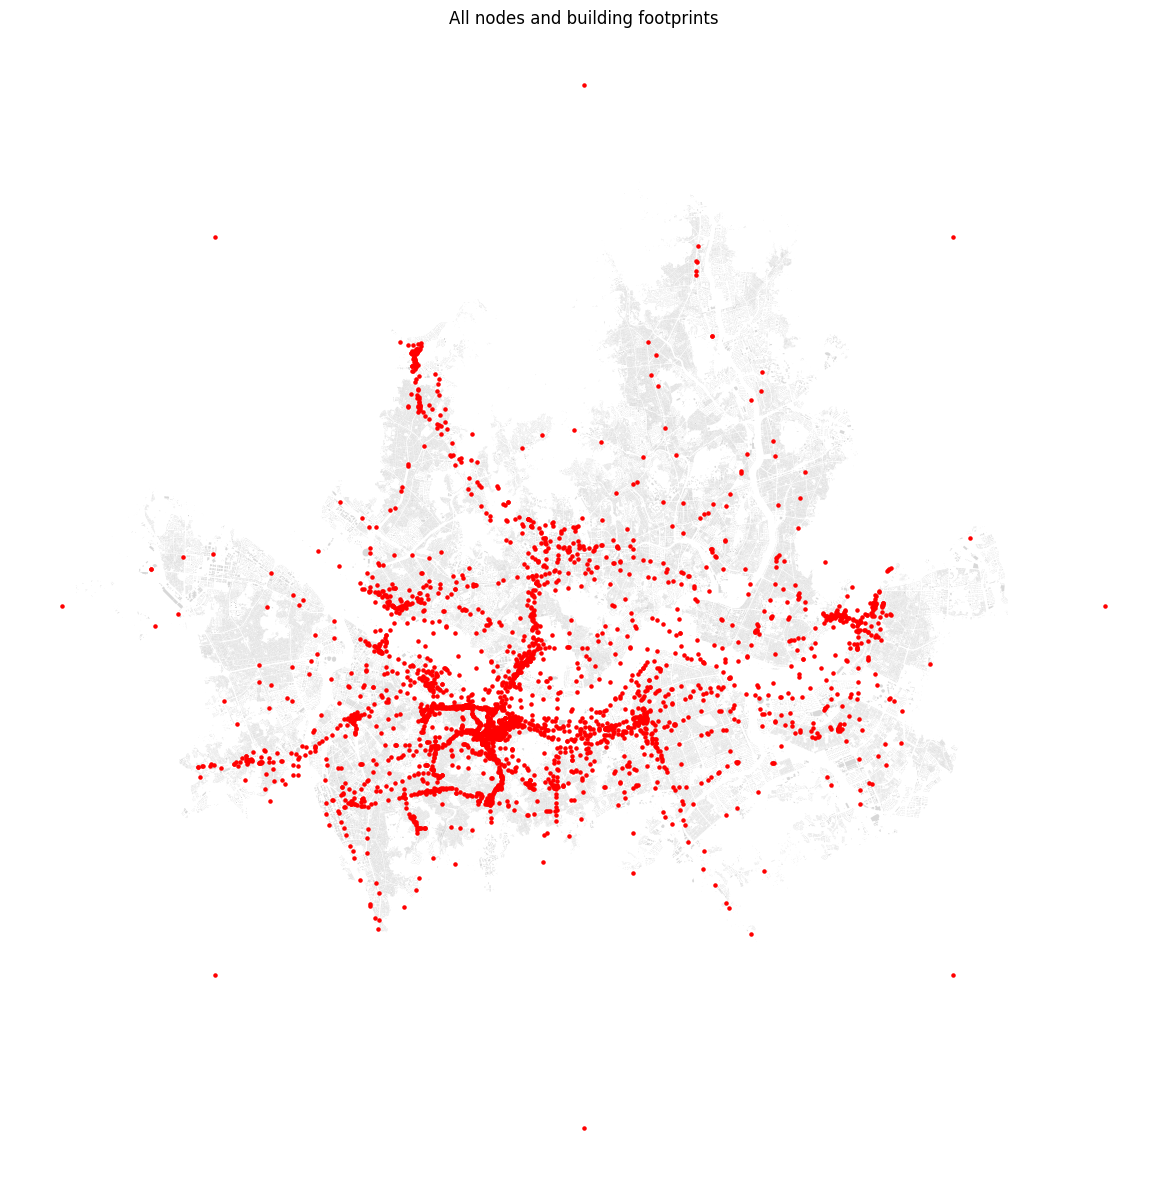

In [96]:
import matplotlib.pyplot as plt

fig2, ax2 = plt.subplots(figsize=(12, 12))
gdf_buildings.plot(ax=ax2, color='grey', alpha=0.3)
gdf_nodes.plot(ax=ax2, color='red', markersize=5)
ax2.set_title('All nodes and building footprints')
ax2.set_axis_off()
plt.tight_layout()
plt.show()

In [106]:
# feature calculations

def calc_GSI(intersected, buffer_area):
    '''
    GSI (Ground Space Index) = Footprint / Area of the buffer 
    '''
    footprint_weighted = (intersected['footprint'] * (intersected['area_overlap'] / intersected.geometry.area)).sum()
    return footprint_weighted / buffer_area if buffer_area > 0 else np.nan


def calc_FSI(intersected, buffer_area):
    '''
    FSI (Floor Space Index) = GFA / Area of the buffer 
    '''
    gfa_weighted = (intersected['gfa'] * (intersected['area_overlap'] / intersected.geometry.area)).sum()
    return gfa_weighted / buffer_area if buffer_area > 0 else np.nan


def calc_OSR(FSI, GSI):
    '''
    OSR (Open Space Ratio) = (1 - GSI) / FSI
    '''
    return (1 - GSI) / FSI if FSI > 0 else np.nan


def calc_ABH(intersected):
    '''
    ABH (Average Building Height) = Average of building heights
    '''
    return intersected['height_1'].mean()


def calc_WMHB(intersected):
    '''
    WMHB (Area-Weighted Mean Building Height) = Sum of (height * footprint) / Sum of footprint
    '''
    heights = intersected['height_1']
    weights = intersected['area_overlap']
    return np.average(heights, weights=weights) if weights.sum() > 0 else np.nan


def calc_HSTD(intersected):
    '''
    HSTD (Standard Deviation of Building Height)'''
    return intersected['height_1'].std()

def calc_GrCR(green_overlap_area, area_buffer):
    '''
    GrCR (Green Coverage Ratio) = Green Area / Area of the buffer
    '''
    return green_overlap_area / area_buffer if area_buffer > 0 else np.nan


def calc_GD(point, green_gdf, green_sindex):
    '''
    GD (Green Distance): distance from the node to the nearest green polygon.
    If the point is inside a green polygon, distance is 0.
    '''
    if green_gdf.contains(point).any():
        return 0.0
    return green_gdf.distance(point).min()

In [107]:
# initializing result columns
gdf_nodes['FSI'] = np.nan
gdf_nodes['GSI'] = np.nan
gdf_nodes['OSR'] = np.nan
gdf_nodes['ABH'] = np.nan
gdf_nodes['WMHB'] = np.nan
gdf_nodes['HSTD'] = np.nan
gdf_nodes['GrCR'] = np.nan

Processing node 93...


C:\Users\Michele\AppData\Local\Temp\ipykernel_8784\2551374606.py:70: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  green_in_buffer_intersection.plot(ax=ax, color='green', alpha=0.7)


93 - 0 of 8: 2.391573936910418, 0.35614985292726564, 0.2692160744586887, 16.791666666666668, 18.935214097469647, 12.816074303911485, 0.0, 335.3846626135045
Processing node 3771...
3771 - 1 of 8: 0.9406187447411536, 0.2784609345308979, 0.7670898219954786, 8.697916666666666, 10.108085840109574, 5.647765821272145, 0.04595888341059242, 37.22802815199489
Processing node 2636...


C:\Users\Michele\AppData\Local\Temp\ipykernel_8784\2551374606.py:61: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  buildings_candidates.plot(ax=ax, color='lightgrey', alpha=0.3)
C:\Users\Michele\AppData\Local\Temp\ipykernel_8784\2551374606.py:67: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  buildings_in_buffer_intersection.plot(ax=ax, color='black')


2636 - 2 of 8: 0.0, 0.0, nan, nan, nan, nan, 0.23715466929397733, 42.51418474049063
Processing node 1338...


C:\Users\Michele\AppData\Local\Temp\ipykernel_8784\2551374606.py:70: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  green_in_buffer_intersection.plot(ax=ax, color='green', alpha=0.7)


1338 - 3 of 8: 0.3951795327622643, 0.11321152129532207, 2.244014188958921, 9.857142857142858, 9.209489351568985, 4.326001122779063, 0.0, 245.5983611901972
Processing node 358...


C:\Users\Michele\AppData\Local\Temp\ipykernel_8784\2551374606.py:70: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  green_in_buffer_intersection.plot(ax=ax, color='green', alpha=0.7)


358 - 4 of 8: 3.698231220489597, 0.33086658535830127, 0.18093336374817426, 22.017241379310345, 34.227644095744274, 16.27018733036824, 0.0, 246.22035807219834
Processing node 2215...


C:\Users\Michele\AppData\Local\Temp\ipykernel_8784\2551374606.py:70: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  green_in_buffer_intersection.plot(ax=ax, color='green', alpha=0.7)


2215 - 5 of 8: 2.4421137266480715, 0.3829844951129815, 0.25265633543361, 10.597014925373134, 21.92523562779721, 14.295644284178797, 0.0, 168.44166544619037
Processing node 2575...


C:\Users\Michele\AppData\Local\Temp\ipykernel_8784\2551374606.py:70: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  green_in_buffer_intersection.plot(ax=ax, color='green', alpha=0.7)


2575 - 6 of 8: 5.088157581315618, 0.34073445345716064, 0.1295686181111507, 54.666666666666664, 37.320018523215246, 56.7650126985511, 0.0, 343.7236041467799
Processing node 1075...


C:\Users\Michele\AppData\Local\Temp\ipykernel_8784\2551374606.py:70: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  green_in_buffer_intersection.plot(ax=ax, color='green', alpha=0.7)


1075 - 7 of 8: 1.0094080284399956, 0.13498917378617376, 0.8569486291392688, 18.848484848484848, 22.063325339656775, 12.713480080512014, 0.0, 130.39565920258607


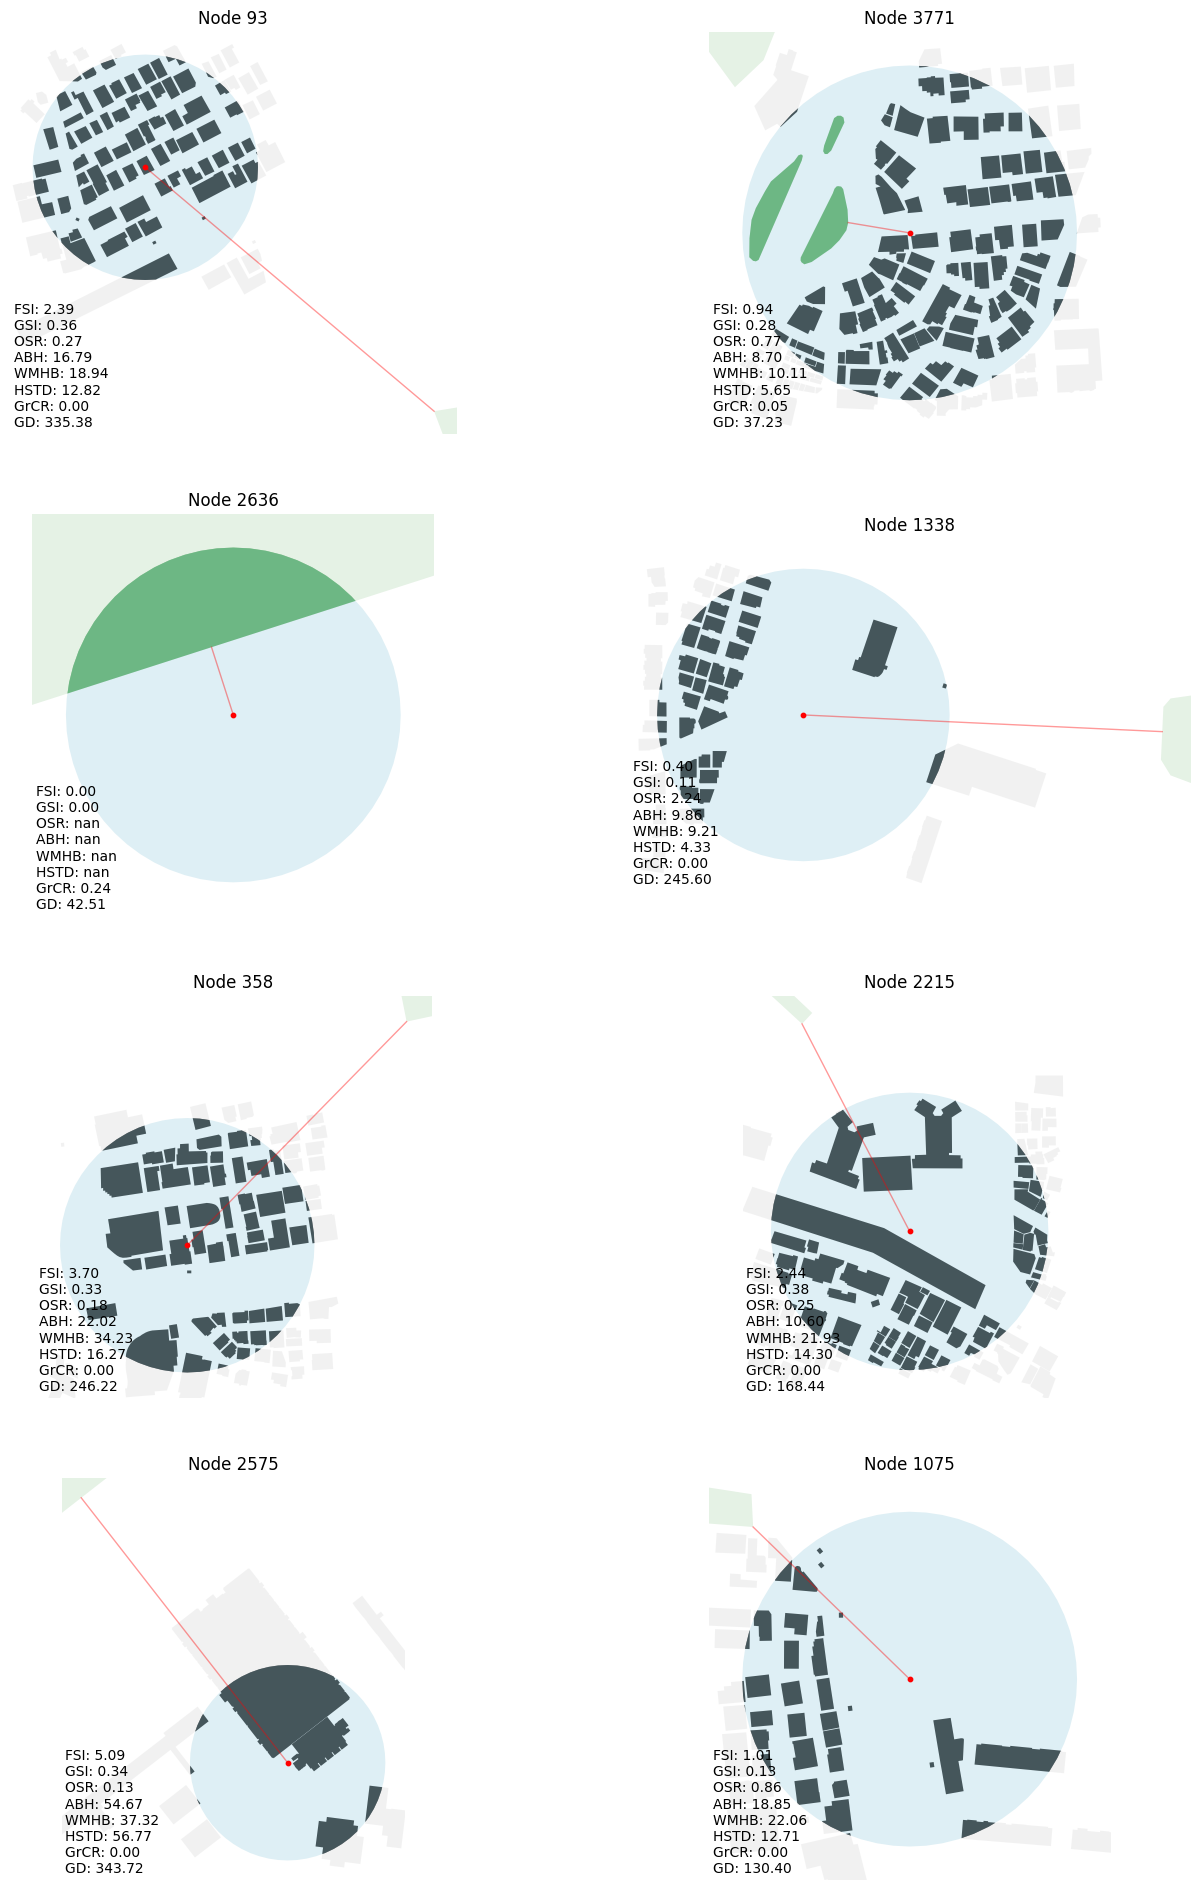

In [ ]:
from shapely.ops import nearest_points

# selecting 8 random nodes
sampled_nodes = gdf_nodes.sample(n=8, random_state=42)

# building spatial index
buildings_sindex = gdf_buildings.sindex
green_sindex = gdf_green.sindex

# creating plots
fig, axes = plt.subplots(4, 2, figsize=(16, 24))
axes = axes.flatten()

for idx, (node_idx, node) in enumerate(sampled_nodes.iterrows()):
        print(f'Processing node {node_idx}...')
        ax = axes[idx]
        buffer_geom = node.geometry.buffer(buffer_radius)

        possible_idx = list(buildings_sindex.intersection(buffer_geom.bounds))
        buildings_candidates = gdf_buildings.iloc[possible_idx]
        buildings_in_buffer = buildings_candidates[buildings_candidates.intersects(buffer_geom)].copy()

        # if buildings_in_buffer.empty:
        #         continue

        buildings_in_buffer['area_overlap'] = buildings_in_buffer.intersection(buffer_geom).area
        
        #print(buildings_in_buffer[['area_overlap']].describe())

        # if buildings_in_buffer['area_overlap'].sum() == 0:
        #         continue

        possible_green_idx = list(green_sindex.intersection(buffer_geom.bounds))
        green_candidates = gdf_green.iloc[possible_green_idx]
        green_in_buffer = green_candidates[green_candidates.intersects(buffer_geom)].copy()

        green_overlap_area = green_in_buffer.intersection(buffer_geom).area.sum()
        fsi = calc_FSI(buildings_in_buffer, buffer_area)
        gsi = calc_GSI(buildings_in_buffer, buffer_area)
        osr = calc_OSR(fsi, gsi)
        abh = calc_ABH(buildings_in_buffer)
        wmhb = calc_WMHB(buildings_in_buffer)
        hstd = calc_HSTD(buildings_in_buffer)
        grcr = calc_GrCR(green_overlap_area, buffer_area)
        gd = calc_GD(node.geometry, gdf_green, green_sindex)

        gdf_nodes.at[idx, 'FSI'] = fsi
        gdf_nodes.at[idx, 'GSI'] = gsi
        gdf_nodes.at[idx, 'OSR'] = osr
        gdf_nodes.at[idx, 'ABH'] = abh
        gdf_nodes.at[idx, 'WMHB'] = wmhb
        gdf_nodes.at[idx, 'HSTD'] = hstd
        gdf_nodes.at[idx, 'GrCR'] = grcr


        # plotting elements
        buffer_gdf = gpd.GeoDataFrame(geometry=[buffer_geom], crs=gdf_nodes.crs)
        node_center = gpd.GeoDataFrame(geometry=[node.geometry], crs=gdf_nodes.crs)

        # background elemetns
        buildings_candidates.plot(ax=ax, color='lightgrey', alpha=0.3)
        #green_candidates.plot(ax=ax, color='green', alpha=0.1)
        gdf_green.plot(ax=ax, color='green', alpha=0.1)

        # buildings and green areas in buffer
        buildings_in_buffer_intersection = buildings_in_buffer.intersection(buffer_geom)
        buildings_in_buffer_intersection.plot(ax=ax, color='black')

        green_in_buffer_intersection = green_in_buffer.intersection(buffer_geom)
        green_in_buffer_intersection.plot(ax=ax, color='green', alpha=0.7)
        
        # buffer and node center
        buffer_gdf.plot(ax=ax, facecolor='lightblue', alpha=0.4)
        node_center.plot(ax=ax, color='red', markersize=10, alpha=1)

        # nearest green area line
        distances = gdf_green.distance(node.geometry)
        min_idx = distances.idxmin()
        nearest_geom = gdf_green.loc[min_idx].geometry

        from shapely.ops import nearest_points
        nearest_point_on_green = nearest_points(node.geometry, nearest_geom)[1]

        ax.plot(
            [node.geometry.x, nearest_point_on_green.x],
            [node.geometry.y, nearest_point_on_green.y],
            color='red', linewidth=1, alpha=0.4
        )

        # setting axis limits slightly outside buffer
        # get bounds of buffer
        xmin, ymin, xmax, ymax = buffer_geom.bounds

        # include green line endpoints
        x_vals = [node.geometry.x, nearest_point_on_green.x]
        y_vals = [node.geometry.y, nearest_point_on_green.y]

        xmin = min(xmin, min(x_vals))
        xmax = max(xmax, max(x_vals))
        ymin = min(ymin, min(y_vals))
        ymax = max(ymax, max(y_vals))

        # add some padding
        padding = buffer_radius * 0.2  # 20% extra
        ax.set_xlim(xmin - padding, xmax + padding)
        ax.set_ylim(ymin - padding, ymax + padding)

        ax.set_title(f'Node {node_idx}')
        ax.set_axis_off()
        ax.text(0.01, 0.01,
            f'FSI: {fsi:.2f}\nGSI: {gsi:.2f}\nOSR: {osr:.2f}\nABH: {abh:.2f}\nWMHB: {wmhb:.2f}\nHSTD: {hstd:.2f}\nGrCR: {grcr:.2f}\nGD: {gd:.2f}',
            transform=ax.transAxes, fontsize=10, verticalalignment='bottom')
    
        print(f'{node_idx} - {idx} of 8: {fsi}, {gsi}, {osr}, {abh}, {wmhb}, {hstd}, {grcr}, {gd}')


# for idx, (node_idx, node) in enumerate(sampled_nodes.iterrows()):
#     ax = axes[idx]
#     buffer_geom = node.geometry.buffer(buffer_radius)
#     buffer_area = np.pi * buffer_radius ** 2

#     # getting building intersections
#     possible_idx = list(buildings_sindex.intersection(buffer_geom.bounds))
#     buildings_candidates = gdf_buildings.iloc[possible_idx]
#     buildings_in_buffer = buildings_candidates[buildings_candidates.intersects(buffer_geom)].copy()
#     buildings_in_buffer['area_overlap'] = buildings_in_buffer.intersection(buffer_geom).area

#     fsi = calc_FSI(buildings_in_buffer, buffer_area)
#     gsi = calc_GSI(buildings_in_buffer, buffer_area)
#     osr = calc_OSR(fsi, gsi)
#     abh = calc_ABH(buildings_in_buffer)
#     wmhb = calc_WMHB(buildings_in_buffer)
#     hstd = calc_HSTD(buildings_in_buffer)

#     # getting green area intersections
#     green_idx = list(green_sindex.intersection(buffer_geom.bounds))
#     green_candidates = gdf_green.iloc[green_idx]
#     green_in_buffer = green_candidates[green_candidates.intersects(buffer_geom)].copy()
#     green_overlap_area = green_in_buffer.intersection(buffer_geom).area.sum()
#     grcr = calc_GrCR(green_overlap_area, buffer_area)

#     # plotting elements
#     gdf_buildings.plot(ax=ax, color='lightgrey', alpha=0.3)
#     buildings_in_buffer.plot(ax=ax, color='black')
#     gdf_green.plot(ax=ax, color='green', alpha=0.2)
#     green_in_buffer.plot(ax=ax, color='green', alpha=0.8)
#     gpd.GeoDataFrame(geometry=[buffer_geom], crs=gdf_nodes.crs).plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1)

#     ax.set_title(f'Node {node_idx}')
#     ax.set_axis_off()
#     ax.text(0.01, 0.01,
#             f'FSI: {fsi:.2f}\nGSI: {gsi:.2f}\nOSR: {osr:.2f}\nABH: {abh:.2f}\nWMHB: {wmhb:.2f}\nHSTD: {hstd:.2f}\nGrCR: {grcr:.2f}',
#             transform=ax.transAxes, fontsize=10, verticalalignment='bottom')
# #     print(f'{node_idx}/8 - FSI: {fsi:.2f}, GSI: {gsi:.2f}, OSR: {osr:.2f}, ABH: {abh:.2f}, WMHB: {wmhb:.2f}, HSTD: {hstd:.2f}, GrCR: {grcr:.2f}')

In [128]:
sampled_nodes = gdf_nodes.sample(n=200, random_state=42)

for idx, (node_idx, node) in enumerate(gdf_nodes.iterrows()):
        buffer_geom = node.geometry.buffer(buffer_radius)

        possible_idx = list(buildings_sindex.intersection(buffer_geom.bounds))
        buildings_candidates = gdf_buildings.iloc[possible_idx]
        buildings_in_buffer = buildings_candidates[buildings_candidates.intersects(buffer_geom)].copy()

        buildings_in_buffer['area_overlap'] = buildings_in_buffer.intersection(buffer_geom).area

        possible_green_idx = list(green_sindex.intersection(buffer_geom.bounds))
        green_candidates = gdf_green.iloc[possible_green_idx]
        green_in_buffer = green_candidates[green_candidates.intersects(buffer_geom)].copy()

        green_overlap_area = green_in_buffer.intersection(buffer_geom).area.sum()
        fsi = calc_FSI(buildings_in_buffer, buffer_area)
        gsi = calc_GSI(buildings_in_buffer, buffer_area)
        osr = calc_OSR(fsi, gsi)
        abh = calc_ABH(buildings_in_buffer)
        wmhb = calc_WMHB(buildings_in_buffer)
        hstd = calc_HSTD(buildings_in_buffer)
        grcr = calc_GrCR(green_overlap_area, buffer_area)
        gd = calc_GD(node.geometry, gdf_green, green_sindex)

        gdf_nodes.at[idx, 'FSI'] = fsi
        gdf_nodes.at[idx, 'GSI'] = gsi
        gdf_nodes.at[idx, 'OSR'] = osr
        gdf_nodes.at[idx, 'ABH'] = abh
        gdf_nodes.at[idx, 'WMHB'] = wmhb
        gdf_nodes.at[idx, 'HSTD'] = hstd
        gdf_nodes.at[idx, 'GrCR'] = grcr
        gdf_nodes.at[idx, 'GD'] = gd
        
        print(f'{idx} of {len(gdf_nodes)} | {node_idx} | FSI: {fsi:.2f}, GSI: {gsi:.2f}, OSR: {osr:.2f}, ABH: {abh:.2f}, WMHB: {wmhb:.2f}, HSTD: {hstd:.2f}, GrCR: {grcr:.2f}, GD: {gd:.2f}')


0 of 3774 | 0 | FSI: 0.00, GSI: 0.00, OSR: nan, ABH: nan, WMHB: nan, HSTD: nan, GrCR: 1.00, GD: 0.00
1 of 3774 | 1 | FSI: 0.00, GSI: 0.00, OSR: nan, ABH: nan, WMHB: nan, HSTD: nan, GrCR: 0.00, GD: 175.58
2 of 3774 | 2 | FSI: 0.00, GSI: 0.00, OSR: nan, ABH: nan, WMHB: nan, HSTD: nan, GrCR: 0.00, GD: 474.40
3 of 3774 | 3 | FSI: 0.00, GSI: 0.00, OSR: nan, ABH: nan, WMHB: nan, HSTD: nan, GrCR: 0.59, GD: 3.73
4 of 3774 | 4 | FSI: 0.00, GSI: 0.00, OSR: nan, ABH: nan, WMHB: nan, HSTD: nan, GrCR: 0.00, GD: 237.10
5 of 3774 | 5 | FSI: 0.00, GSI: 0.00, OSR: nan, ABH: nan, WMHB: nan, HSTD: nan, GrCR: 0.71, GD: 0.00
6 of 3774 | 6 | FSI: 0.00, GSI: 0.00, OSR: nan, ABH: nan, WMHB: nan, HSTD: nan, GrCR: 0.00, GD: 4079.89
7 of 3774 | 7 | FSI: 0.00, GSI: 0.00, OSR: nan, ABH: nan, WMHB: nan, HSTD: nan, GrCR: 0.60, GD: 0.00
8 of 3774 | 8 | FSI: 1.58, GSI: 0.43, OSR: 0.36, ABH: 9.00, WMHB: 11.02, HSTD: 5.51, GrCR: 0.00, GD: 41.78
9 of 3774 | 9 | FSI: 1.38, GSI: 0.31, OSR: 0.50, ABH: 10.50, WMHB: 13.12, HS

In [ ]:
# set the parameters of cardinal nodes to NaN

for i in range(8):
    gdf_nodes.at[i, 'FSI'] = np.nan
    gdf_nodes.at[i, 'GSI'] = np.nan
    gdf_nodes.at[i, 'OSR'] = np.nan
    gdf_nodes.at[i, 'ABH'] = np.nan
    gdf_nodes.at[i, 'WMHB'] = np.nan
    gdf_nodes.at[i, 'HSTD'] = np.nan
    gdf_nodes.at[i, 'GrCR'] = np.nan
    gdf_nodes.at[i, 'GD'] = np.nan


In [ ]:
parameters = ['FSI', 'GSI', 'OSR', 'ABH', 'WMHB', 'HSTD', 'GrCR', 'GD']

for param in parameters:
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf_nodes.plot(ax=ax, column=param, cmap='viridis', legend=True, markersize=20, alpha=0.8)
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Gray, crs=gdf_nodes.crs.to_string())
    ax.set_title(f'{param} across Seoul')
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

In [51]:
# iterating through each node and calculating the urban features

buildings_sindex = gdf_buildings.sindex
green_sindex = gdf_green.sindex

for idx, node in gdf_nodes.iterrows():
    buffer_geom = node.geometry.buffer(buffer_radius)

    possible_idx = list(buildings_sindex.intersection(buffer_geom.bounds))
    buildings_candidates = gdf_buildings.iloc[possible_idx]
    buildings_in_buffer = buildings_candidates[buildings_candidates.intersects(buffer_geom)].copy()

    if buildings_in_buffer.empty:
        continue

    buildings_in_buffer['area_overlap'] = buildings_in_buffer.intersection(buffer_geom).area
        
    #print(buildings_in_buffer[['area_overlap']].describe())

    if buildings_in_buffer['area_overlap'].sum() == 0:
        continue

    fsi = calc_FSI(buildings_in_buffer, buffer_area)
    gsi = calc_GSI(buildings_in_buffer, buffer_area)
    osr = calc_OSR(fsi, gsi)
    abh = calc_ABH(buildings_in_buffer)
    wmhb = calc_WMHB(buildings_in_buffer)
    hstd = calc_HSTD(buildings_in_buffer)

    possible_green_idx = list(green_sindex.intersection(buffer_geom.bounds))
    green_candidates = gdf_green.iloc[possible_green_idx]
    green_in_buffer = green_candidates[green_candidates.intersects(buffer_geom)].copy()

    green_overlap_area = green_in_buffer.intersection(buffer_geom).area.sum()
    grcr = calc_GrCR(green_overlap_area, buffer_area)

    gdf_nodes.at[idx, 'FSI'] = fsi
    gdf_nodes.at[idx, 'GSI'] = gsi
    gdf_nodes.at[idx, 'OSR'] = osr
    gdf_nodes.at[idx, 'ABH'] = abh
    gdf_nodes.at[idx, 'WMHB'] = wmhb
    gdf_nodes.at[idx, 'HSTD'] = hstd
    gdf_nodes.at[idx, 'GrCR'] = grcr
    print(f'{idx}/{len(gdf_nodes)}: {fsi}, {gsi}, {osr}, {abh}, {wmhb}, {hstd}, {grcr}')


8/3774: 1.5839822259282088, 0.42654306666393427, 0.3620349546536242, 9.0, 970.1786118310049, 5.510050429688, 0.001668729616322349
9/3774: 1.376143281976183, 0.31227911435629097, 0.49974511713353076, 10.5, 795.509105342711, 5.255815398738618, 0.22746839609904668
10/3774: 0.5339830105979907, 0.0864127619337188, 1.710891957111489, 22.666666666666668, 47.465579412100816, 27.31910198621714, 0.5533992331756967
11/3774: 1.7343977130046622, 0.4238708052231626, 0.33217824865483364, 11.991735537190083, 1205.0162656596817, 2.8852956745326095, 0.0
12/3774: 0.41207380772543345, 0.07401666513553766, 2.2471298041865575, 16.733333333333334, 191.3941292716046, 13.30663994653296, 0.23524489968609236
13/3774: 0.4556349607798067, 0.13198087077390155, 1.9050757820262687, 9.24390243902439, 323.34124301285465, 4.035966351475679, 0.0
14/3774: 6.55117115662769, 0.3464363552244926, 0.09976287127139244, 51.333333333333336, 264.0505418109983, 49.57883223776661, 0.0
15/3774: 1.1268304055797973, 0.3684186323039119,

KeyboardInterrupt: 

In [ ]:
output = gdf_nodes.drop(columns='geometry').copy()
output.to_csv(output_csv, index=False)
print(f"urban metrics saved to: {output_csv}")